# Mitigating Bias with MinDiff Model Remediation

## Learning Objectives
- Learn the concept of equal opportunity fairness.
- Learn how to apply MinDiff method to a TensorFlow model to mitigate bias.

## Introduction
In this notebook, we’ll train a text classifier to identify written content that could be considered toxic or harmful, and apply MinDiff to remediate some fairness concerns. In our workflow, we will:
1.   Train and evaluate our baseline model’s performance on text containing references to sensitive groups.
2.   Improve performance on any underperforming groups by training with MinDiff.
3.   Evaluate the new model’s performance on our chosen metric.

The purpose of this notebook is to demonstrate the usage of the MinDiff technique with a very minimal workflow, not to lay out a principled approach to fairness in machine learning. As such, our evaluation will only focus on one sensitive category and a single metric. We also don’t address potential shortcomings in the dataset, nor tune our configurations in this notebook. 

In a production setting, you would want to approach each of these with rigor. For more information on evaluating for fairness, see [this guide](https://www.tensorflow.org/responsible_ai/fairness_indicators/guide/guidance).


Import all necessary components, including MinDiff in TensorFlow Model Remediation library.

In [1]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

In [2]:
import copy

import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_model_remediation.min_diff as md
from tensorflow_model_remediation.tools.tutorials_utils import (
    min_diff_keras_utils,
)

## Prepare Dataset

We use a utility function to download the preprocessed data and prepare the labels to match the model’s output shape. The function also downloads the data as TFRecords to make later evaluation quicker. Alternatively, you may convert the Pandas DataFrame into TFRecords with any available utility conversion function.


In [3]:
(
    data_train,
    data_validate,
    _,
    _,
    _,
) = min_diff_keras_utils.download_and_process_civil_comments_data()

324941336/324941336 [==============================] - 5s 0us/step


Let's take a look at the dataset.

In [4]:
data_train

,comment_text,toxicity,gender,sexual_orientation,religion,race,disability
0,Someone should do better homework before they ...,0,[],[],[],[],[]
1,Are you mental? It took so long to extinguish...,0,[],[],[],[],[]
2,I doubt you know enough about international tr...,0,[],[],[],[],[]
3,It's a total disincentive. Love the losers o...,0,[],[],[],[],[]
4,There are other reasons nobody's following thr...,0,[],[],[],[],[]
...,...,...,...,...,...,...,...
1082919,A very good point. ZLB gives you exposure to a...,0,[],[],[],[],[]
1082920,It is clear cut. Right down to the fact that o...,0,[],[],[],[],[]
1082921,Where is the humanity in so many of these comm...,0,[],[],[],[],['psychiatric_or_mental_illness']
1082922,Richard You will make many people happy when ...,0,[],[],[],[],[]


The `comment_text` column has text feature and `toxicity` has the label which represents whether the text is toxic or not (1 or 0).

In [5]:
data_train[data_train["toxicity"] == 1].head()

,comment_text,toxicity,gender,sexual_orientation,religion,race,disability
7,The more Hillary opens her mouth the more she ...,1,['female'],[],[],[],[]
12,"All you ever talk about is trolling, you and y...",1,[],[],[],[],[]
17,"Look, another ignorant, slobbering, mouthbreat...",1,[],[],[],[],[]
18,Comment on the update: It still sucks.,1,[],[],[],[],[]
31,But that men who engage in sex with prostitute...,1,"['male', 'female']",[],[],[],[]


<Axes: xlabel='toxicity', ylabel='Count'>

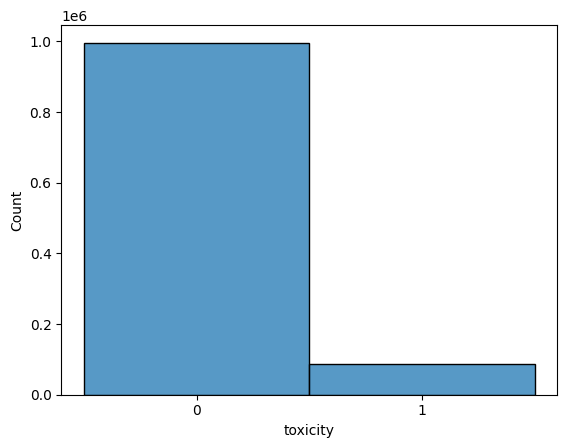

In [6]:
sns.histplot(data_train.toxicity.apply(str))

It looks like the positive (toxic) data is much fewer than the negative (non-toxic) data.

We define a few constants. Note that the batch size here is chosen arbitrarily, but in a production setting you would need to tune it for best performance.

In [7]:
TEXT_FEATURE = "comment_text"
LABEL = "toxicity"
BATCH_SIZE = 512

We convert the training data from pandas dataframe to tf.data, and create a generator that yields a batch.

We also convert our Pandas DataFrames into Tensorflow Datasets.  Note that unlike the Keras model API for Pandas DataFrames, using Datasets means that we need to provide the model’s input features and labels together in one Dataset. Here we provide the `'comment_text'` as an input feature and reshape the label to match the model's expected output.

We batch the Dataset at this stage, too.

In [8]:
def make_dataset(df, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(
        (
            df[TEXT_FEATURE].values,
            df[LABEL].values,
        )
    ).batch(batch_size)
    return dataset


dataset_train_main = make_dataset(data_train, BATCH_SIZE)
dataset_valid_main = make_dataset(data_validate, BATCH_SIZE)

## Define and train the baseline model

Let's define a simple baseline model to classify the text toxicity. It is a simple Keras sequential model with an initial embedding and dense layers, outputting a toxicity prediction. 

In [9]:
def build_model():
    hub_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"

    model = tf.keras.Sequential()

    # Embedding layer.
    hub_layer = hub.KerasLayer(
        hub_url, output_shape=[128], input_shape=[], dtype=tf.string
    )
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    return model


baseline_model = build_model()

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()
baseline_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

history = baseline_model.fit(
    x=dataset_train_main, batch_size=BATCH_SIZE, epochs=1
)

2116/2116 [==============================] - 21s 9ms/step - loss: 0.2518 - accuracy: 0.9177


In [11]:
valid_result = baseline_model.evaluate(dataset_valid_main)
print(f"Validation Accuracy: {valid_result[1]}")

1411/1411 [==============================] - 13s 9ms/step - loss: 0.2322 - accuracy: 0.9214
Validation Accuracy: 0.9214169979095459


## Prepare data splits for MinDiff

To use MinDiff, we create two additional data splits:
* A split for non-toxic examples referencing minority groups: In our case, this will include comments with references to our underperforming identity terms.  We don’t include some of the groups because there are too few examples, leading to higher uncertainty with wide confidence interval ranges.
* A split for non-toxic examples referencing the majority group.

It’s important to have sufficient examples belonging to the underperforming classes. Based on your model architecture, data distribution, and MinDiff configuration, the amount of data needed can vary significantly. In past applications, we have seen MinDiff work well with 5,000 examples in each data split.

In our case, the groups in the minority splits have example quantities of 9,688 and 3,906. Note the class imbalances in the dataset; in practice, this could be cause for concern, but we won’t seek to address them in this notebook since our intention is just to demonstrate MinDiff.  

We select only negative examples for these groups, so that MinDiff can optimize on getting these examples right. It may seem counterintuitive to carve out sets of ground truth *negative* examples if we’re primarily concerned with disparities in *false positive rate (FPR)*, but remember that a false positive prediction is a ground truth negative example that’s incorrectly classified as positive, which is the issue we’re trying to address.

### Create splits with DataFrame

First, let's create the splits using pandas DataFrame.

Note how we define majority and minority in this dataset. And we filter out positive example.

In [12]:
def create_mindiff_datasets(df):
    # Create masks for the sensitive and nonsensitive groups
    minority_mask = df.religion.apply(
        lambda x: any(religion in x for religion in ("jewish", "muslim"))
    )
    majority_mask = df.religion.apply(lambda x: x == "['christian']")

    # Select nontoxic examples, so MinDiff will be able to reduce sensitive FP rate.
    true_negative_mask = df["toxicity"] == 0

    data_sensitive = df[minority_mask & true_negative_mask]
    data_nonsensitive = df[majority_mask & true_negative_mask]
    return data_sensitive, data_nonsensitive


data_train_sensitive, data_train_nonsensitive = create_mindiff_datasets(
    data_train
)
data_valid_sensitive, data_valid_nonsensitive = create_mindiff_datasets(
    data_validate
)

Now we got two DataFrames for majority and minority.

In [13]:
data_train_sensitive.head()

,comment_text,toxicity,gender,sexual_orientation,religion,race,disability
114,Corresponding with relatives in The Netherland...,0,[],[],['muslim'],[],[]
150,The muslim faith has told the world they\ninte...,0,[],[],['muslim'],[],[]
307,The bitter irony of this anti-settlement narra...,0,[],[],['jewish'],[],[]
358,"re: Baber, the local zealot, angrily walks int...",0,[],[],['muslim'],[],[]
393,Soros is the money source for almost all the m...,0,[],[],['muslim'],[],[]


In [14]:
data_train_nonsensitive.head()

,comment_text,toxicity,gender,sexual_orientation,religion,race,disability
28,It's people like Demboski that give Christians...,0,[],[],['christian'],[],[]
29,Quite a misstatement. The pope shows great ba...,0,[],[],['christian'],[],[]
290,Just more evidence that NCR is the vanguard of...,0,[],[],['christian'],[],[]
300,Fine. Oppose the death penalty all you want. ...,0,[],[],['christian'],[],[]
309,This is not our first trip through your privac...,0,[],[],['christian'],[],[]


### Create MinDiff Datasets

Then, we wrap them in tf.data.Dataset using the `make_dataset` function defined above.

Note that we tune the batch size selection the same way it is tuned for the baseline model, taking into account training speed and hardware considerations while balancing with model performance. Here we have chosen the same batch size for all three datasets but this is not a requirement, although it’s good practice to have the two MinDiff batch sizes be equivalent.

In [15]:
dataset_train_sensitive = make_dataset(data_train_sensitive, BATCH_SIZE)
dataset_train_nonsensitive = make_dataset(data_train_nonsensitive, BATCH_SIZE)
dataset_valid_sensitive = make_dataset(data_valid_sensitive, BATCH_SIZE)
dataset_valid_nonsensitive = make_dataset(data_valid_nonsensitive, BATCH_SIZE)

## Baseline Model Evaluation
### Check the Prediction distribution

Now we have two data splits.

Let's take a look at the prediction distribution for majority (nonsensitive) and minority (sensitive) classes using the baseline model.<br>
Please remember that we only use negative examples, so ideally the predictions should be closer to 0.0.

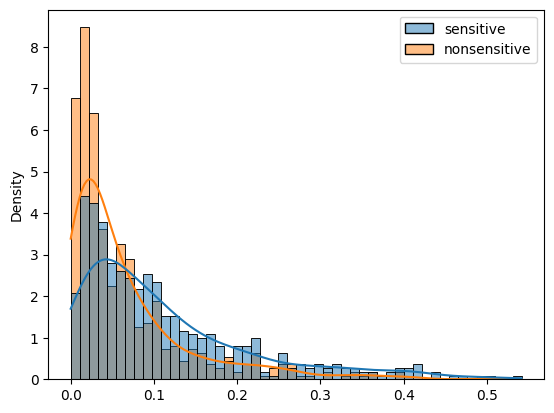

In [16]:
def visualize_pred_histogram(model):
    for (f, l), (non_f, non_l) in zip(
        dataset_valid_sensitive.take(1), dataset_valid_nonsensitive.take(1)
    ):
        res = tf.squeeze(model(f))
        non_res = tf.squeeze(model(non_f))
        sns.histplot(
            {"sensitive": res, "nonsensitive": non_res},
            bins=50,
            kde=True,
            stat="density",
        )


visualize_pred_histogram(baseline_model)

We can see a distribution difference between splits, and the minority dataset has lower confidence for the negative cases, that will lead to higher false positives.

### Check FPR

In [17]:
def false_positive_rate(y_true, y_pred, thresholds):
    fp = tf.keras.metrics.FalsePositives(thresholds=thresholds)
    fp.update_state(y_true, y_pred)
    fp = fp.result().numpy()

    tn = tf.keras.metrics.TrueNegatives(thresholds=thresholds)
    tn.update_state(y_true, y_pred)
    tn = tn.result().numpy()
    return fp / (fp + tn)

In [18]:
def compute_fpr(model, thresholds=0.5):
    nonsensitive_prediction = model.predict(
        data_train_nonsensitive[TEXT_FEATURE], batch_size=BATCH_SIZE, verbose=3
    )
    sensitive_prediction = model.predict(
        data_train_sensitive[TEXT_FEATURE], batch_size=BATCH_SIZE, verbose=3
    )

    nonsensitive_fpr = false_positive_rate(
        data_train_nonsensitive[LABEL].values,
        nonsensitive_prediction,
        thresholds=thresholds,
    )
    sensitive_fpr = false_positive_rate(
        data_train_sensitive[LABEL].values,
        sensitive_prediction,
        thresholds=thresholds,
    )

    print(f"Nonsensitive FPR: {nonsensitive_fpr:>5.5f}")
    print(f"Sensitive FPR: {sensitive_fpr:>10.5f}")

In [19]:
compute_fpr(baseline_model, thresholds=0.2)

Nonsensitive FPR: 0.06693
Sensitive FPR:    0.16239


We can see the baseline model is performing differently on different splits.

## Define and Train the MinDiff Model

Now, we’ll try to improve the FPR for underperforming religious groups. We’ll attempt to do so using [MinDiff](https://arxiv.org/abs/1910.11779), a remediation technique that seeks to balance error rates across slices of your data by penalizing disparities in performance during training. When we apply MinDiff, model performance may degrade slightly on other slices. As such, our goals with MinDiff will be:
*   Improved performance for underperforming groups
*   Limited degradation for other groups and overall performance



To train with MinDiff, we have to follow these steps:

- Define the model architecture
- Wrap it in a MinDiffModel with a corresponding `loss` and `loss_weight`.  
- Compile the model normally (using the regular non-MinDiff loss) and fit to train. 

For the loss definition, we use 1.5 as the default `loss_weight`, which means how we prioritize the MinDiff loss over the primary cross entropy loss, but this is a parameter that needs to be tuned for your use case, since it depends on your model and product requirements.<br>
You can experiment with changing the value to see how it impacts the model, noting that increasing it pushes the performance of the minority and majority groups closer together but may come with more pronounced tradeoffs.

In [20]:
original_model = build_model()

min_diff_loss = md.losses.MMDLoss()
min_diff_weight = 1.5

min_diff_model = md.keras.MinDiffModel(
    original_model, min_diff_loss, min_diff_weight
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()
min_diff_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

And we also defines the dataset that will be passed to the MinDiffModel during training.

Here we repeat the dataset so that we can train on the same amount as the base model for comparison.

In [21]:
min_diff_dataset = md.keras.utils.input_utils.pack_min_diff_data(
    original_dataset=dataset_train_main,
    sensitive_group_dataset=dataset_train_sensitive,
    nonsensitive_group_dataset=dataset_train_nonsensitive,
)

min_diff_dataset = min_diff_dataset.repeat(
    int(
        dataset_train_main.cardinality()
        // dataset_train_sensitive.cardinality()
    )
)

Now let's execute the MinDiff training.

In [22]:
history = min_diff_model.fit(min_diff_dataset, epochs=1)

2100/2100 [==============================] - 79s 36ms/step - loss: 0.2460 - accuracy: 0.9211 - min_diff_loss: 0.0015


Next we evaluate the results.  

## MinDiff Model Evaluation

Let's take a look at the result by visualizing the prediction distribution again.

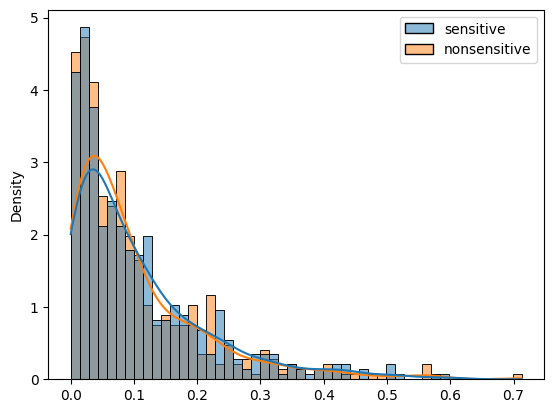

In [23]:
visualize_pred_histogram(min_diff_model)

This looks much better sicce the distributions are closer compared to the baseline model.

Let's check the FPR as we did for the baseline model.

In [24]:
compute_fpr(min_diff_model, thresholds=0.2)

Nonsensitive FPR: 0.14785
Sensitive FPR:    0.15022


FPRs for sensitive and nonsensitive datasets are also very close!

In a production setting, we have to pick a threshold to ensure that the model behavior meets launch standards.<br>
This threshold may be different from the one you selected for the baseline model. Try selecting false positive rate with threshold 0.300.

In [25]:
compute_fpr(min_diff_model, thresholds=0.3)

Nonsensitive FPR: 0.06241
Sensitive FPR:    0.06706


Copyright 2024 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License